C:\Users\mexis\AppData\Local\Temp\ipykernel_18660\2022476281.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Dataset size: (96, 9)


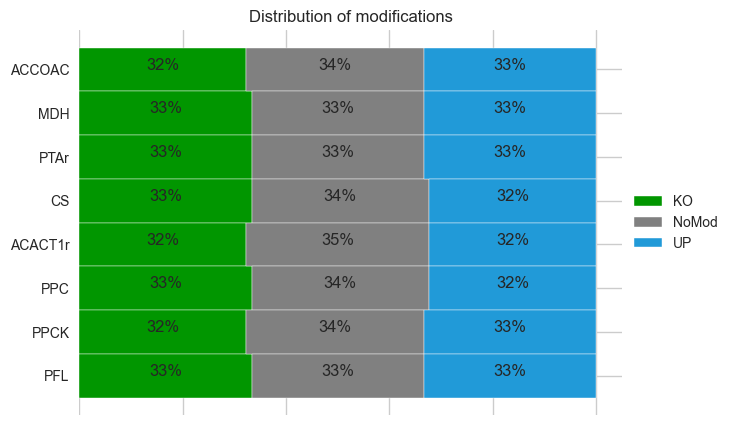

In [1]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

from src import plot_multiomics
from straindesignxai.main import DataLoader

file_path = "../data/EDD_isoprenol_production.csv"
model_path = "../models/xgb_isoprenol.pkl"

input_var = ["ACCOAC", "MDH", "PTAr", "CS", "ACACT1r", "PPC", "PPCK", "PFL"]
response_var = ["Value"]

d = DataLoader(file_path, input_var, response_var)
plot_multiomics.plot_distribution_of_designs(d.df.drop("Value", axis=1))

In [2]:
# How many designs improve production over the WT
print(
    len(d.df[d.df["Value"] > d.df.loc["WT"]["Value"]]),
    "designs out of",
    len(d.df),
    "improve production over the WT",
)

11 designs out of 96 improve production over the WT


[15:24:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.



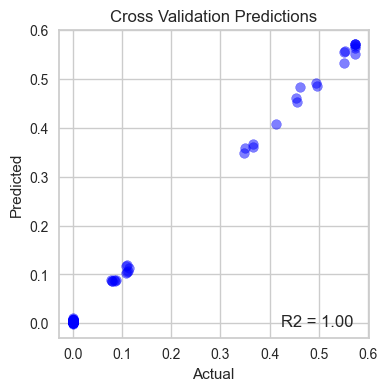

In [3]:
# load or train ml model
try:
    d.load_model(model_path)
except FileNotFoundError:
    d.train_xgb(n_iter=500)
    d.save_model(model_path)

d.plot_R2()

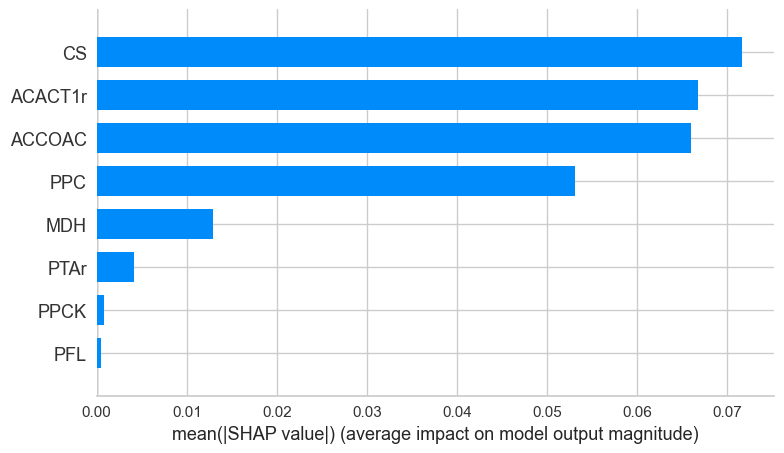

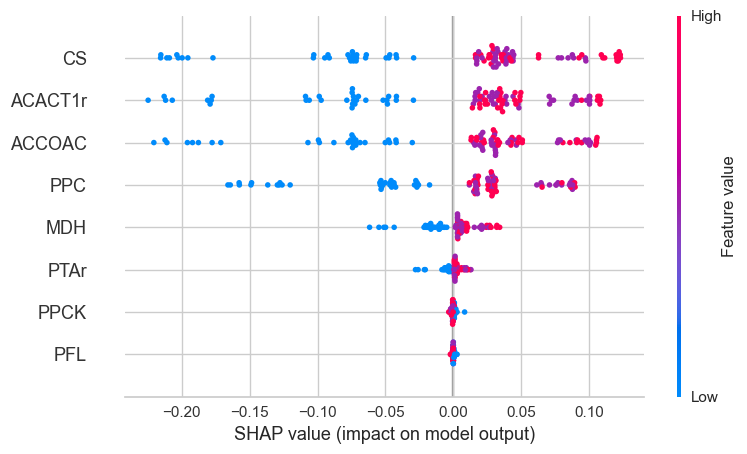

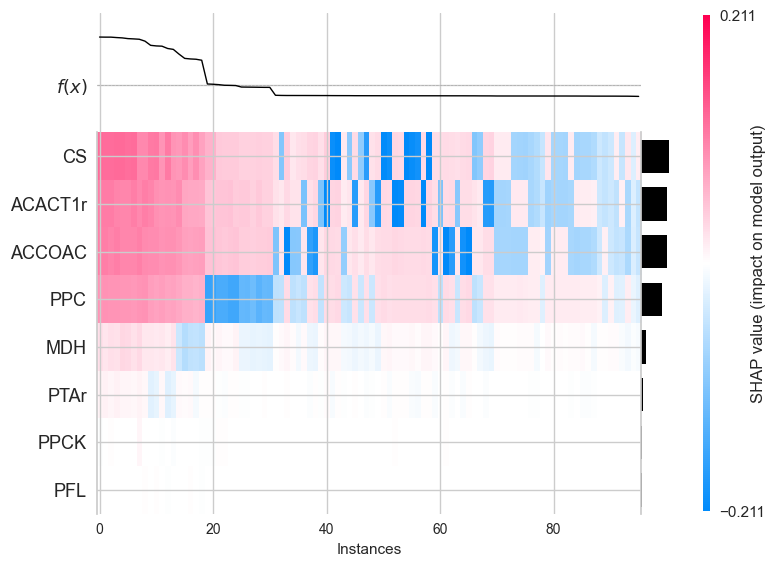

In [4]:
d.get_shap_values()

### Sort columns of `shap_df` by absolute `mean`/`man` shap values

In [5]:
# Sort columns of d.shap_df by mean absolute shap value
d.shap_df = d.shap_df.reindex(
    np.abs(d.shap_df).mean().sort_values(ascending=False).index, axis=1
)
np.abs(d.shap_df).describe().loc["max"]

CS         0.215608
ACACT1r    0.224800
ACCOAC     0.220575
PPC        0.166008
MDH        0.061654
PTAr       0.027843
PPCK       0.008366
PFL        0.002814
Name: max, dtype: float64

### Supervised clustering

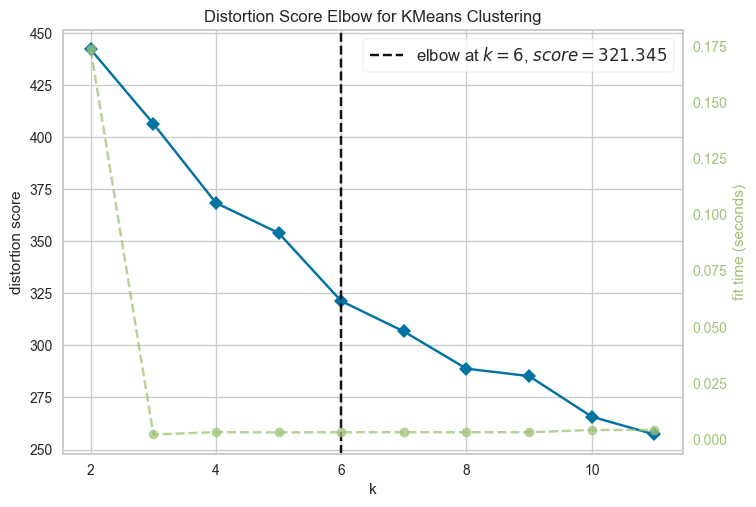

Optimal number of clusters: 6


In [6]:
d.supervised_clustering()

In [7]:
d.df["pred"] = d.model.predict(d.df.drop(["Value", "cluster"], axis=1))
# find cluster with highest mean predicted value
top_cluster = (
    d.df.groupby("cluster").mean().sort_values("pred", ascending=False).index[0]
)
d.df[d.df["cluster"] == top_cluster]

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value,cluster,pred
Line Name,,,,,,,,,,,
Strain 2,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0.552101,0,0.554696
Strain 3,1.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0,0.349196,0,0.358057
Strain 4,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.551849,0,0.533084
Strain 7,2.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,0.572648,0,0.571667
Strain 17,2.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,0.495097,0,0.492459
Strain 36,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,0.348023,0,0.348508
Strain 38,1.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,0.365749,0,0.366300
Strain 41,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,0.572648,0,0.564361
Strain 46,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,0.572648,0,0.572483


### Partial Dependence and Scatter Plots

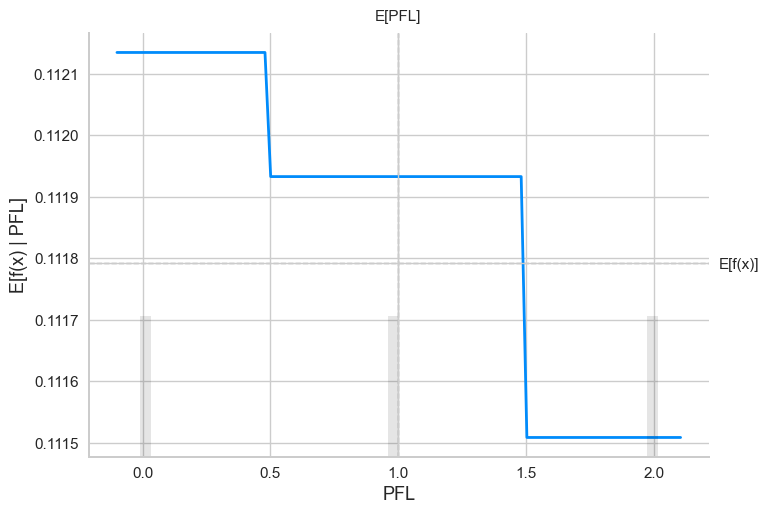

In [8]:
d.pdplot("PFL")

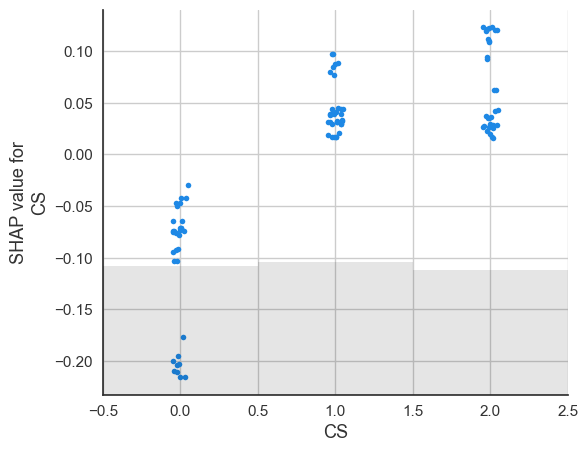

In [9]:
d.shap_scatter("CS")

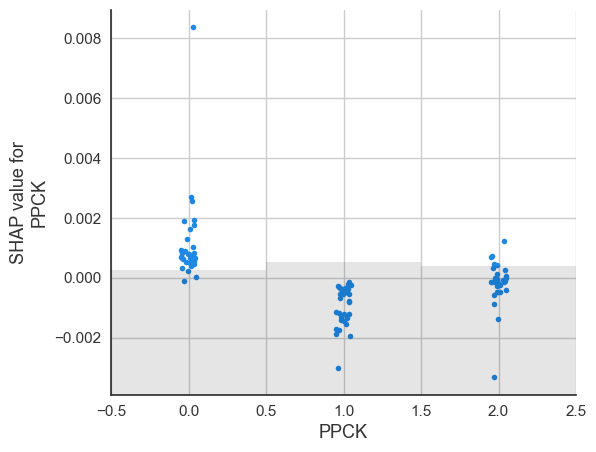

In [10]:
d.shap_scatter("PPCK")

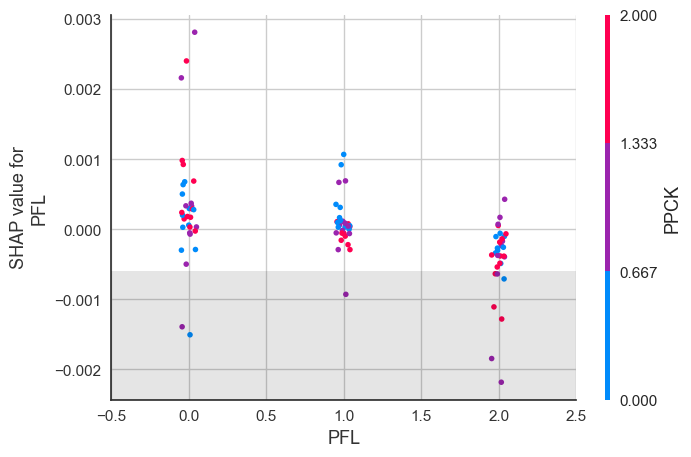

In [11]:
d.shap_scatter("PFL", "PPCK")

### Sampling

In [12]:
d.shap_df[d.shap_df["cluster"] == top_cluster]

,CS,ACACT1r,ACCOAC,PPC,MDH,PTAr,PPCK,PFL,cluster,Value
1,0.120350,0.106185,0.100437,0.085606,0.024727,0.008219,-0.001228,-0.001391,0,0.552101
2,0.092622,0.072286,0.077587,0.061536,-0.049853,-0.008365,-0.000473,0.000926,0,0.349196
3,0.097680,0.106512,0.097136,0.089756,0.020903,0.008044,-0.001552,0.002814,0,0.551849
6,0.120620,0.108635,0.105503,0.089387,0.022048,0.012534,0.001635,-0.000487,0,0.572648
16,0.110206,0.100570,0.094482,0.080033,0.021103,-0.025922,0.000903,-0.000708,0,0.495097
35,0.077344,0.070653,0.080728,0.064666,-0.054770,0.001891,-0.001951,-0.001845,0,0.348023
37,0.094671,0.073882,0.078850,0.065412,-0.061654,0.004646,-0.000019,-0.001281,0,0.365749
40,0.123180,0.100355,0.099731,0.086268,0.034206,0.009572,-0.001173,0.000429,0,0.572648
45,0.123044,0.107657,0.105912,0.087793,0.026719,0.010760,-0.001887,0.000692,0,0.572648
47,0.122194,0.100562,0.105505,0.089000,0.026154,0.013048,-0.001314,0.000670,0,0.572648


In [13]:
clstr_df = d.study_clusters("most_frequent", verbose=False)
clstr_df.sort_values("pred", ascending=False, inplace=True)
clstr_df = clstr_df.head(1)

bounds = pd.DataFrame(index=d.X.columns, columns=["lower", "upper"])
# bounds.loc['CS'] = [0, 2]
for col in d.X.columns:
    l_b = clstr_df[col].values[0] - 1
    u_b = clstr_df[col].values[0]
    bounds.loc[col] = [l_b, u_b]

# Gerate samples from a Latin hypercube generator
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=d.X.shape[1])
sample = sampler.random(100000)
LB = bounds["lower"].values.tolist()
UB = bounds["upper"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=d.X.columns)
sample_df = sample_df.round(0).astype(int)
sample_df["pred"] = d.model.predict(sample_df)
# Drop duplicates
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False)

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,pred
258,1,2,1,2,1,1,0,1,0.570705
726,1,2,1,2,1,1,0,2,0.569201
325,1,2,1,2,1,1,1,2,0.564361
1015,1,2,1,2,1,1,1,1,0.562735
271,1,1,1,2,1,1,0,1,0.554392
...,...,...,...,...,...,...,...,...,...
391,0,1,1,2,0,0,1,1,-0.000839
86,0,1,1,2,0,0,1,2,-0.000839
74,0,1,1,2,0,0,0,2,-0.000839
151,0,1,0,2,0,0,1,2,-0.001067


In [14]:
bounds

,lower,upper
ACCOAC,0.0,1.0
MDH,1.0,2.0
PTAr,0.0,1.0
CS,1.0,2.0
ACACT1r,0.0,1.0
PPC,0.0,1.0
PPCK,0.0,1.0
PFL,1.0,2.0


### Sampling

In [21]:
top_df = d.df[d.df["cluster"] == top_cluster].copy()

df_x_train = top_df.drop(["Value", "cluster", "pred"], axis=1)  
df_y_train = pd.DataFrame(top_df["Value"])

discrete_columns = df_x_train.columns.tolist()

In [26]:
from ctgan import CTGAN

ctgan = CTGAN(epochs=100)
ctgan.fit(df_x_train, discrete_columns)

In [28]:
synthetic_data = ctgan.sample(100)
synthetic_data['pred'] = d.model.predict(synthetic_data)
synthetic_data.sort_values('pred', ascending=False)

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,pred
68,2.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0,0.592842
14,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.589733
84,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.589733
2,2.0,2.0,2.0,2.0,1.0,2.0,0.0,1.0,0.583014
18,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,0.577001
...,...,...,...,...,...,...,...,...,...
69,1.0,0.0,1.0,2.0,1.0,1.0,0.0,2.0,0.361060
99,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.356665
97,1.0,0.0,2.0,1.0,1.0,1.0,1.0,2.0,0.350796
28,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.347708
